# Background

This project explores skin cancer HAM10000 (Human Against Machine with 10000 training images) dataset obtained from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T).

From the authors:
> We collected dermatoscopic images from different populations acquired and stored by different modalities. Given this diversity we had to apply different acquisition and cleaning methods and developed semi-automatic workflows utilizing specifically trained neural networks. The final dataset consists of 11788 dermatoscopic images, of which 10010 will be released as a training set for academic machine learning purposes and will be publicly available through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions. More than 50% of lesions have been confirmed by pathology, the ground truth for the rest of the cases was either follow-up, expert consensus, or confirmation by in-vivo confocal microscopy.

This dataset will be first explored by EDA and various CNN models (including custom NN model and transfer learning with ResNET50) will be trained in order to classify the following classes of skin cancer:
1. Melanocytic nevi 
2. Melanoma 
3. Benign keratosis-like lesions 
4. Basal cell carcinoma 
5. Actinic keratoses 
6. Vascular lesions 
7. Dermatofibroma  

# Loading libraries

In [1]:
import os
import cv2
from glob import glob

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.utils import np_utils
from keras import layers
from keras.layers import Input,Dense,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,ZeroPadding2D,GlobalAveragePooling2D,Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


# Data loading / overview

In [2]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}

In [3]:
df_sd = pd.read_csv(os.path.join('HAM10000_metadata.csv'))

df_sd['path'] = df_sd['image_id'].map(imageid_path_dict.get)
df_sd['cell_type'] = df_sd['dx'].map(lesion_type_dict.get) 
df_sd['cell_type_idx'] = pd.Categorical(df_sd['cell_type']).codes

#### Data structure

In [4]:
df_sd.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9870,HAM_0004439,ISIC_0031672,akiec,histo,55.0,female,face,HAM10000_images_part_2\ISIC_0031672.jpg,Actinic keratoses,0
917,HAM_0005463,ISIC_0032315,bkl,consensus,45.0,male,back,HAM10000_images_part_2\ISIC_0032315.jpg,Benign keratosis-like lesions,2
6266,HAM_0002422,ISIC_0031566,nv,follow_up,60.0,male,lower extremity,HAM10000_images_part_2\ISIC_0031566.jpg,Melanocytic nevi,4
770,HAM_0000999,ISIC_0029927,bkl,confocal,70.0,female,face,HAM10000_images_part_2\ISIC_0029927.jpg,Benign keratosis-like lesions,2
8415,HAM_0007545,ISIC_0027129,nv,histo,35.0,female,trunk,HAM10000_images_part_1\ISIC_0027129.jpg,Melanocytic nevi,4


#### Data info

In [5]:
df_sd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id        10015 non-null object
image_id         10015 non-null object
dx               10015 non-null object
dx_type          10015 non-null object
age              9958 non-null float64
sex              10015 non-null object
localization     10015 non-null object
path             10015 non-null object
cell_type        10015 non-null object
cell_type_idx    10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.0+ KB


In [6]:
print('<number of missing values>')
df_sd.isnull().sum()[df_sd.isnull().sum()>0]

<number of missing values>


age    57
dtype: int64

In [7]:
df_sd.age = df_sd.age.fillna(df_sd.age.median()).astype(int)

57 `age` values were missing. They were filled with median of the age for EDA.

# EDA
#### Count plots of different variables (`cell_type`, `localization`, `dx_type` and `age`)

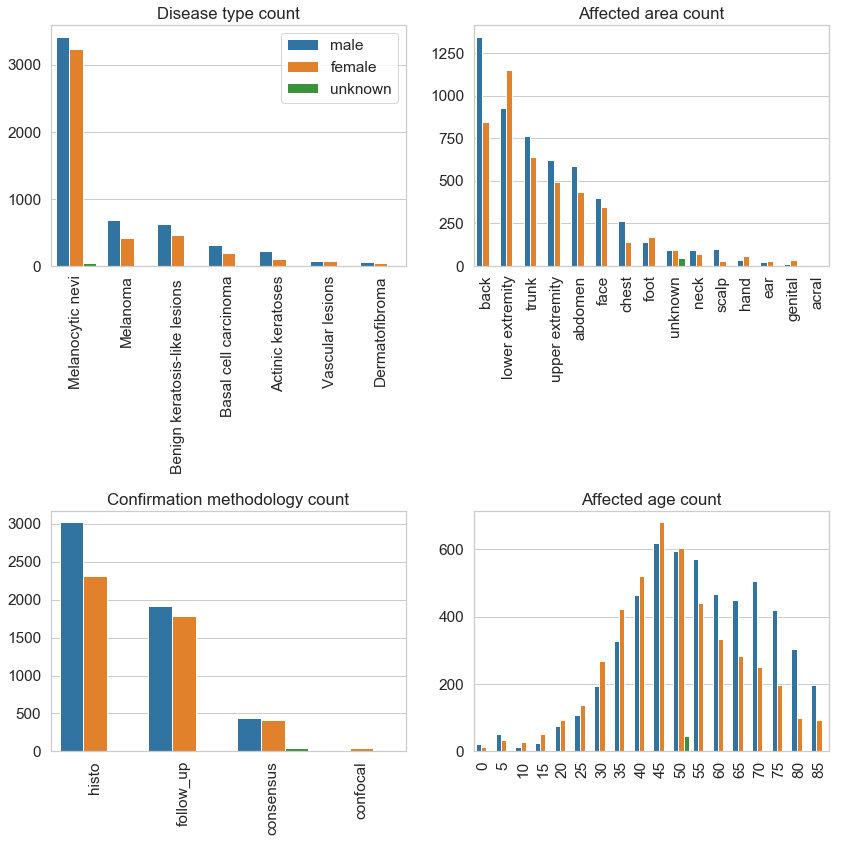

In [8]:
sns.set_style('whitegrid')
sns.set_context('notebook',font_scale=1.4)

titles = ['Disease type count','Affected area count','Confirmation methodology count','Affected age count']
yvals = ['cell_type','localization','dx_type','age']

fig,axes = plt.subplots(2,2,figsize=(12,12))
for ax,title,yval in zip(axes.flatten(),titles,yvals):
    if ax != axes.flatten()[3]:
        order = df_sd[yval].value_counts().index
    else:
        order = None
    sns.countplot(yval,data=df_sd,hue='sex',ax=ax,order=order)
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    ax.legend(loc=1)
    if ax != axes.flatten()[0]:
        ax.legend().set_visible(False)         
plt.tight_layout()        

Regarding the 7 classes of skin cancer, this dataset is highly imbalanced towards *Melanocytic nevi*. The performance of constructed models may need to be compared with that of the dummy classifier that simply predicts *Melanocytic nevi* at all times.

#### Age distribution based on `cell-type` and `localization`

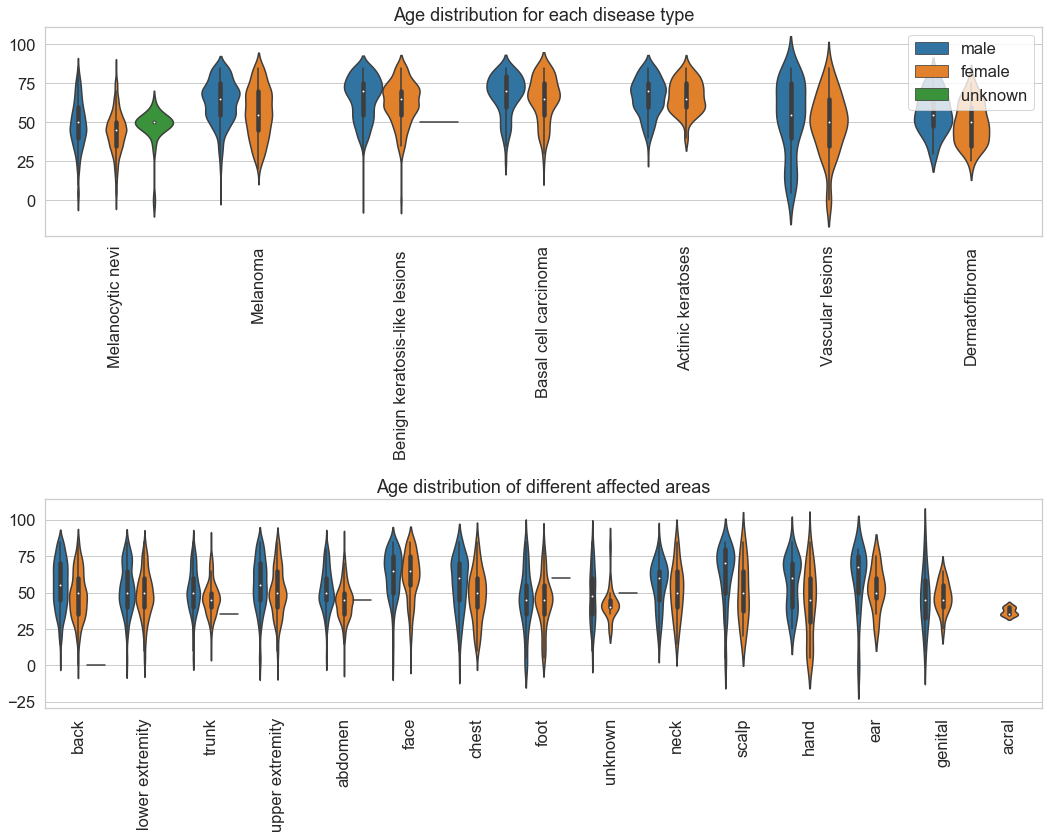

In [9]:
plt.figure(figsize=(15,12))
sns.set_context('notebook',font_scale=1.5)
plt.subplot(211)
sns.violinplot('cell_type','age',hue='sex',data=df_sd,order =df_sd.cell_type.value_counts().index)
plt.title('Age distribution for each disease type')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.legend(loc=1)
plt.subplot(212)
sns.violinplot('localization','age',hue='sex',data=df_sd,order =df_sd.localization.value_counts().index)
plt.title('Age distribution of different affected areas')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.legend().set_visible(False)
plt.tight_layout()

Most skin cancer classes seem to occur in patents older than 50. For various skin cancer classes and affected area, gender seem to have small effects.  

# Image loading and preprocessing

In [10]:
df_sd['image'] = df_sd.path.map(cv2.imread)

#### Due to the limited memory, the image has to be resized to 75X100

In [11]:
img_rows = 75 #450/6
img_cols = 100 #600/6
img_channels = 3
df_sd['image_resized'] = df_sd['image'].map(lambda x: cv2.resize(x,(img_cols,img_rows)))

#### Some examples of 7 different skin cancer types

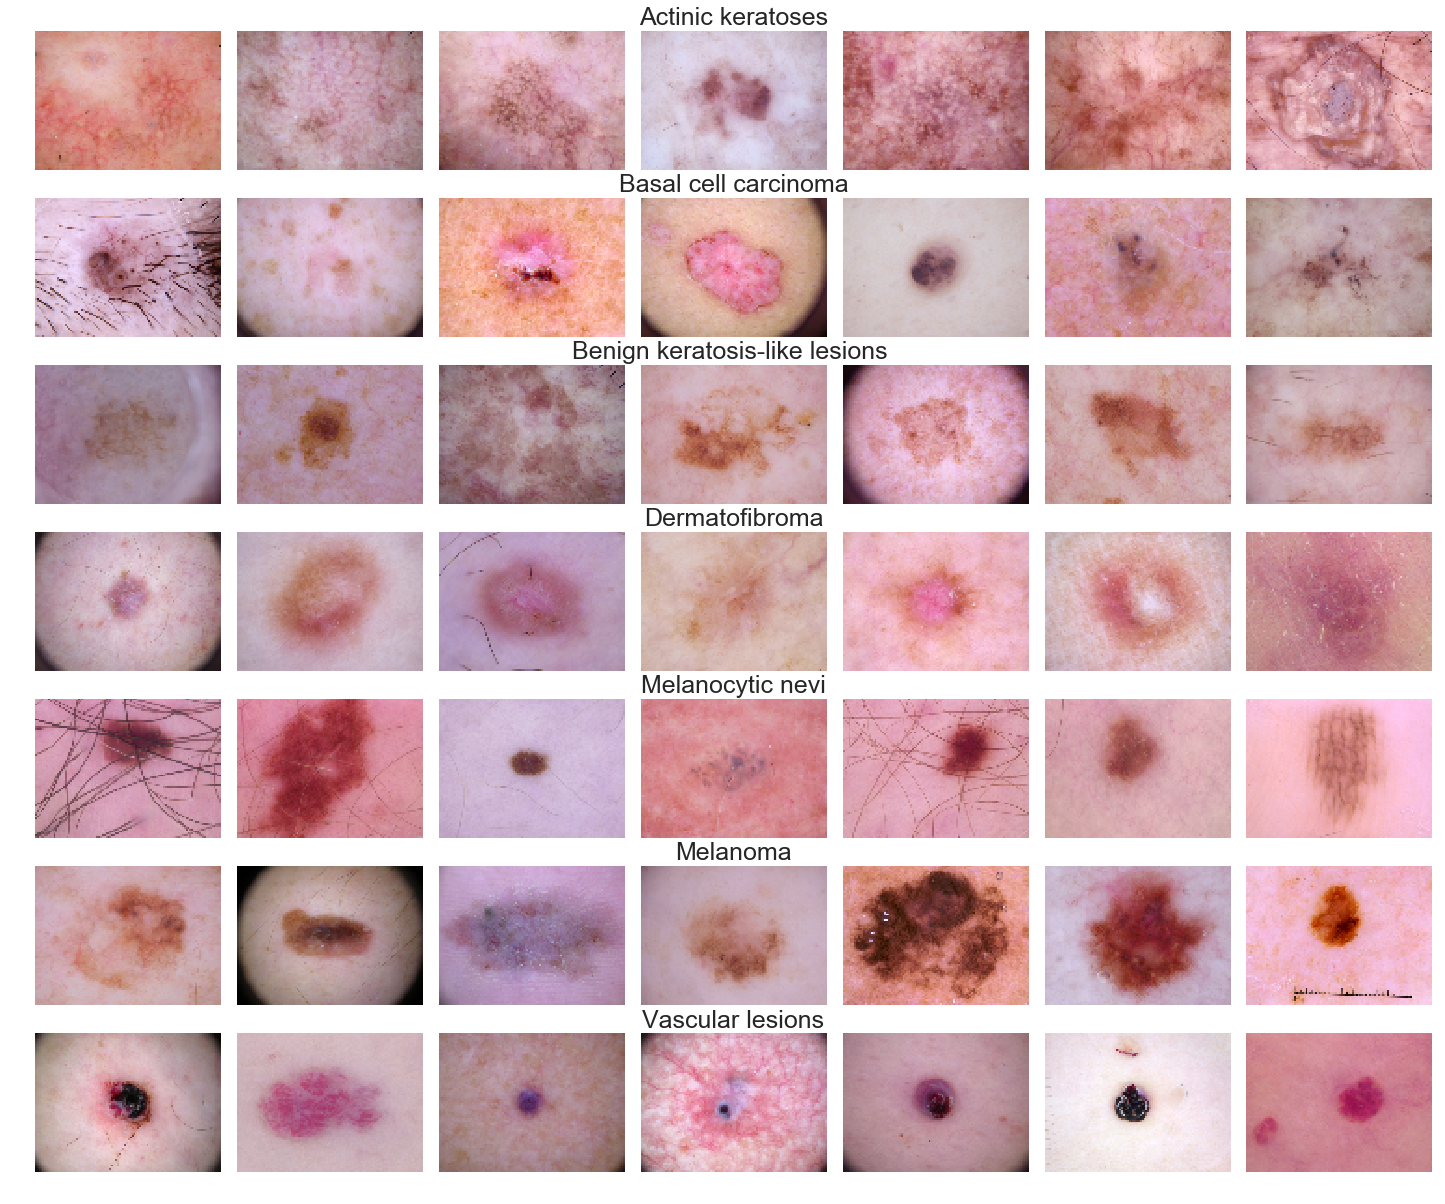

In [12]:
n_samples = 7
fig, row = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for col, (type_name, type_rows) in zip(row, df_sd.groupby('cell_type')):
    col[3].set_title(type_name,fontsize=25)
    for col_ax, (dummy, col_row) in zip(col, type_rows.sample(n_samples, random_state=0).iterrows()):
        img = cv2.cvtColor(col_row['image_resized'], cv2.COLOR_BGR2RGB)
        col_ax.imshow(img)
        col_ax.axis('off')
plt.subplots_adjust(left=0.2, wspace=0.01)

#### Checking tensor shape of all images in the dataset

In [13]:
df_sd['image_resized'].map(lambda x: x.shape).unique()

array([(75, 100, 3)], dtype=object)

#### Image standarization

In [14]:
image_data_list = []
for m in range(len(df_sd)):
    input_flat = df_sd.image_resized[m].flatten()
    image_data_list.append(input_flat)
img_data = np.array(image_data_list)
img_data_scaled = scale(img_data)
img_data_scaled = img_data_scaled.reshape(img_data.shape[0],img_rows,img_cols,img_channels)

#### One-hot-encoding of the target variable

In [15]:
y = df_sd['cell_type_idx']
y = np_utils.to_categorical(y,7)

In [16]:
X_shuffled, y_shuffled = shuffle(img_data_scaled,y,random_state=0)

#### Cehkcing tensor shapes of train/dev/test sets

In [17]:
X_train,X_dev_test,y_train,y_dev_test = train_test_split(X_shuffled,y_shuffled,test_size=0.05,random_state=0,stratify=y_shuffled)
X_dev,X_test,y_dev,y_test = train_test_split(X_dev_test,y_dev_test,test_size=0.5,random_state=0,stratify=y_dev_test)
print('X_train shape:' +str(X_train.shape))
print('y_train shape:' +str(y_train.shape))
print('X_dev shape:' +str(X_dev.shape))
print('y_dev shape:' +str(y_dev.shape))
print('X_test shape:' +str(X_test.shape))
print('y_test shape:' +str(y_test.shape))

X_train shape:(9514, 75, 100, 3)
y_train shape:(9514, 7)
X_dev shape:(250, 75, 100, 3)
y_dev shape:(250, 7)
X_test shape:(251, 75, 100, 3)
y_test shape:(251, 7)


# Dummy classifier

In [18]:
y_dev_df = pd.DataFrame(y_dev,columns=['Actinic keratoses','Basal cell carcinoma','Benign keratosis-like lesions',
                            'Dermatofibroma','Melanocytic nevi','Melanoma','Vascular lesions'])
y_dev_df.sum()/len(y_dev_df)*100

Actinic keratoses                 3.200000
Basal cell carcinoma              5.200000
Benign keratosis-like lesions    10.800000
Dermatofibroma                    1.200000
Melanocytic nevi                 66.799995
Melanoma                         11.200001
Vascular lesions                  1.600000
dtype: float32

A dummy classifier that predicts all as `Melanocytic nevi` shows ~66.8% accuracy due to the imbalanced dataset. The classifier needs to be tuned carefully so that it does not become this type of a dummy classifier.

# Defining callback and required functions for model comparison

#### `save_best_model` callback function save the best model in terms of `val_loss`
#### `learning_rate_reduction` callback function decreases the learning rate by a factor of 0.5 when there is no improvement in `val_loss` during the three consecutive steps

In [19]:
filepath_1 = 'best-wiehgts-model_1-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5'
filepath_2 = 'best-wiehgts-model_2-{epoch:03d}-{val_loss:.3f}-{val_acc:.3f}.hdf5'

save_best_model_1 = ModelCheckpoint(filepath_1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
save_best_model_2 = ModelCheckpoint(filepath_2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',patience=3,verbose=1,factor=0.5,min_lr=0.00001)


#### `training_plot` creates `loss` and `accuracy` learning curve over epochs

In [20]:
def training_plot(hist):
    loss = [hist.history['loss'],hist.history['val_loss']]
    acc = [hist.history['acc'],hist.history['val_acc']]
    
    fig, ax = plt.subplots(1,2,figsize = (15,3))
    for i,val,name in zip(range(len(ax)),(loss,acc),['loss','accuracy']):
        ax[i].plot(val[0], color='b', label="Training")
        ax[i].plot(val[1], color='r', label="Validation")
        ax[i].legend(loc='best')
        ax[i].set_xlabel('epoch')
        ax[i].set_ylabel('')
        ax[i].set_title(name)

#### `confusion_matrix_plot` creates normal, normalized confusion matrixs and correct prediction rate for each cancer class

In [21]:
def confusion_matrix_plot(y_true,y_pred,model_name):
    
    confusion_mtx = confusion_matrix(y_true,y_pred_classes)
    confusion_mtx_normalized = confusion_mtx/confusion_mtx.sum(axis=1).reshape(7,1)

    plt.figure(figsize=(8,4))
    sns.heatmap(confusion_mtx,annot=True,cmap='coolwarm',fmt='d')
    plt.title('confusion matrix of '+ model_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    plt.figure(figsize=(8,4))
    sns.heatmap(confusion_mtx_normalized,annot=True,cmap='coolwarm')
    plt.title('Normalized confusion matrix of '+ model_name)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    plt.figure()
    plt.title('Correct prediction rate (%) of ' + model_name)
    sns.barplot(np.arange(7),np.diag(confusion_mtx_normalized)*100)
    plt.xlabel('Cell type index')

In [22]:
optimizer = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=10**-8, amsgrad=False)
epochs = 100
batch_size = 32

# Model_1 - custom CNN

In [23]:
X_input = Input((img_rows,img_cols,img_channels))

X1 = Conv2D(16, (3, 3), strides = (1, 1),padding='same')(X_input)
X1 = Activation('relu')(X1)
X1 = Conv2D(16, (3, 3), strides = (1, 1),padding='same')(X1)
X1 = Activation('relu')(X1)
X1 = MaxPooling2D((2, 2))(X1)
X1 = Dropout(0.6)(X1)

X1 = Conv2D(32, (3, 3), strides = (1, 1),padding='same')(X1)
X1 = Activation('relu')(X1)
X1 = Conv2D(32, (3, 3), strides = (1, 1),padding='same')(X1)
X1 = Activation('relu')(X1)
X1 = MaxPooling2D((2, 2))(X1)
X1 = Dropout(0.6)(X1)

X1 = Flatten()(X1)
X1 = Dense(64)(X1)
X1 = Activation('relu')(X1)
X1 = Dropout(0.6)(X1)
X1 = Dense(7, activation = 'softmax')(X1)
model_1 = Model(inputs = X_input, outputs = X1)

model_1.compile(optimizer = optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
hist_1 = model_1.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=(X_dev,y_dev),callbacks=[save_best_model_1,learning_rate_reduction])

Train on 9514 samples, validate on 250 samples
Epoch 1/100
9514/9514 [==============================] - 20s 2ms/step - loss: 1.0990 - acc: 0.6560 - val_loss: 1.0635 - val_acc: 0.6680

Epoch 00001: val_loss improved from inf to 1.06350, saving model to best-wiehgts-model_1-001-1.064-0.668.hdf5
Epoch 2/100
9514/9514 [==============================] - 6s 665us/step - loss: 0.9614 - acc: 0.6686 - val_loss: 0.9467 - val_acc: 0.6680

Epoch 00002: val_loss improved from 1.06350 to 0.94666, saving model to best-wiehgts-model_1-002-0.947-0.668.hdf5
Epoch 3/100
9514/9514 [==============================] - 6s 669us/step - loss: 0.8997 - acc: 0.6755 - val_loss: 0.9982 - val_acc: 0.6280

Epoch 00003: val_loss did not improve from 0.94666
Epoch 4/100
9514/9514 [==============================] - 6s 660us/step - loss: 0.8741 - acc: 0.6767 - val_loss: 0.8525 - val_acc: 0.6800

Epoch 00004: val_loss improved from 0.94666 to 0.85248, saving model to best-wiehgts-model_1-004-0.852-0.680.hdf5
Epoch 5/100
9

9514/9514 [==============================] - 6s 658us/step - loss: 0.6200 - acc: 0.7625 - val_loss: 0.6853 - val_acc: 0.7560

Epoch 00037: val_loss did not improve from 0.67327

Epoch 00037: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 38/100
9514/9514 [==============================] - 6s 659us/step - loss: 0.6096 - acc: 0.7629 - val_loss: 0.6841 - val_acc: 0.7600

Epoch 00038: val_loss did not improve from 0.67327
Epoch 39/100
9514/9514 [==============================] - 6s 658us/step - loss: 0.6095 - acc: 0.7583 - val_loss: 0.6837 - val_acc: 0.7560

Epoch 00039: val_loss did not improve from 0.67327
Epoch 40/100
9514/9514 [==============================] - 6s 658us/step - loss: 0.6138 - acc: 0.7578 - val_loss: 0.6787 - val_acc: 0.7440

Epoch 00040: val_loss did not improve from 0.67327

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 41/100
9514/9514 [==============================] - 6s 658us/step - loss: 0.6122 - a

9514/9514 [==============================] - 6s 660us/step - loss: 0.6019 - acc: 0.7679 - val_loss: 0.6813 - val_acc: 0.7560

Epoch 00079: val_loss did not improve from 0.67327
Epoch 80/100
9514/9514 [==============================] - 6s 665us/step - loss: 0.5961 - acc: 0.7686 - val_loss: 0.6841 - val_acc: 0.7560

Epoch 00080: val_loss did not improve from 0.67327
Epoch 81/100
9514/9514 [==============================] - 6s 665us/step - loss: 0.5904 - acc: 0.7667 - val_loss: 0.6832 - val_acc: 0.7520

Epoch 00081: val_loss did not improve from 0.67327
Epoch 82/100
9514/9514 [==============================] - 6s 663us/step - loss: 0.6005 - acc: 0.7731 - val_loss: 0.6844 - val_acc: 0.7560

Epoch 00082: val_loss did not improve from 0.67327
Epoch 83/100
9514/9514 [==============================] - 6s 665us/step - loss: 0.5946 - acc: 0.7681 - val_loss: 0.6817 - val_acc: 0.7520

Epoch 00083: val_loss did not improve from 0.67327
Epoch 84/100
9514/9514 [==============================] - 6s 66

In [24]:
model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 100, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 100, 16)       448       
_________________________________________________________________
activation_1 (Activation)    (None, 75, 100, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 16)       2320      
_________________________________________________________________
activation_2 (Activation)    (None, 75, 100, 16)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 16)        0         
__________

#### Model_1 learning curve

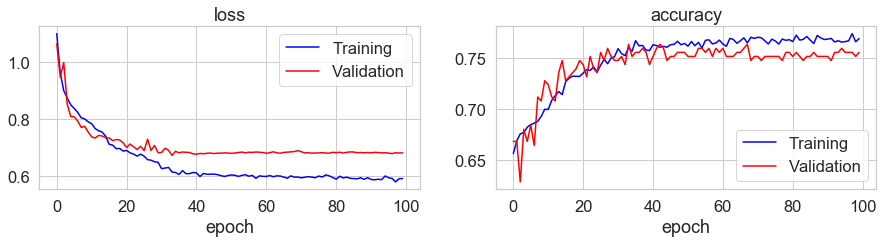

In [25]:
training_plot(hist_1)

#### Model_1 evaluation (using best weights in terms of val_loss)

In [26]:
model_1 = load_model('best-wiehgts-model_1-034-0.673-0.764.hdf5')
dev_loss, dev_accuracy = model_1.evaluate(X_dev, y_dev, verbose=1)
test_loss, test_accuracy = model_1.evaluate(X_test, y_test, verbose=1)
print("Dev: accuracy = %f  ;  loss = %f" % (dev_accuracy, dev_loss))
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

251/251 [==============================] - 0s 524us/step
Dev: accuracy = 0.764000  ;  loss = 0.673267
Test: accuracy = 0.772908  ;  loss = 0.629032


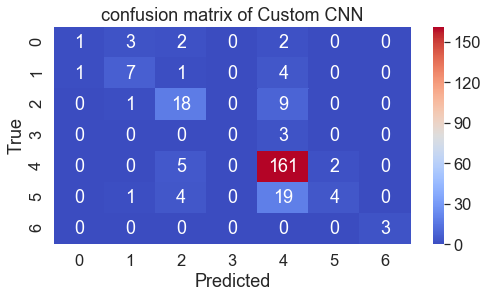

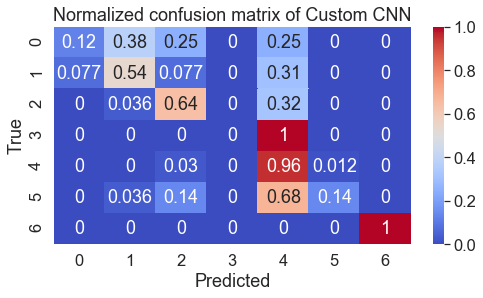

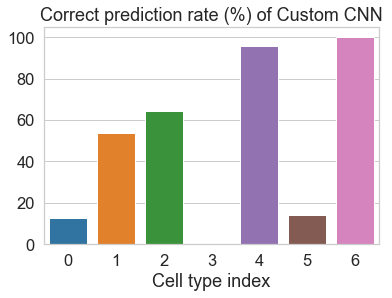

In [27]:
y_pred = model_1.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test,axis=1)
confusion_matrix_plot(y_true,y_pred_classes,'Custom CNN')

# Model_2 - Transfer learning from VGG16 (Finetuning)

In [28]:
model_2 = VGG16(include_top=False, weights='imagenet',input_tensor=X_input)
last_layer = model_2.get_layer('block5_pool').output
X2 = Flatten(name='flatten')(last_layer)
X2 = Dense(128,activation='relu',name='fc1')(X2)
X2 = Dense(7,activation='softmax',name='output')(X2)
model_2 = Model(inputs = X_input, outputs = X2)

#### Freeze the pre-trained weights

In [29]:
for layer in model_2.layers[:-3]:
    layer.trainable = False
model_2.compile(optimizer = optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
hist_2 = model_2.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=(X_dev,y_dev),callbacks=[save_best_model_2,learning_rate_reduction])

Train on 9514 samples, validate on 250 samples
Epoch 1/100
9514/9514 [==============================] - 15s 2ms/step - loss: 1.0499 - acc: 0.6532 - val_loss: 0.9034 - val_acc: 0.6840

Epoch 00001: val_loss improved from inf to 0.90338, saving model to best-wiehgts-model_2-001-0.903-0.684.hdf5
Epoch 2/100
9514/9514 [==============================] - 13s 1ms/step - loss: 0.8724 - acc: 0.6940 - val_loss: 0.8502 - val_acc: 0.6920

Epoch 00002: val_loss improved from 0.90338 to 0.85018, saving model to best-wiehgts-model_2-002-0.850-0.692.hdf5
Epoch 3/100
9514/9514 [==============================] - 13s 1ms/step - loss: 0.8228 - acc: 0.7054 - val_loss: 0.8180 - val_acc: 0.7000

Epoch 00003: val_loss improved from 0.85018 to 0.81798, saving model to best-wiehgts-model_2-003-0.818-0.700.hdf5
Epoch 4/100
9514/9514 [==============================] - 13s 1ms/step - loss: 0.7898 - acc: 0.7157 - val_loss: 0.7959 - val_acc: 0.7240

Epoch 00004: val_loss improved from 0.81798 to 0.79593, saving mode

9514/9514 [==============================] - 13s 1ms/step - loss: 0.5451 - acc: 0.8049 - val_loss: 0.6448 - val_acc: 0.8000

Epoch 00033: val_loss improved from 0.64617 to 0.64480, saving model to best-wiehgts-model_2-033-0.645-0.800.hdf5
Epoch 34/100
9514/9514 [==============================] - 13s 1ms/step - loss: 0.5401 - acc: 0.8068 - val_loss: 0.6414 - val_acc: 0.7960

Epoch 00034: val_loss improved from 0.64480 to 0.64136, saving model to best-wiehgts-model_2-034-0.641-0.796.hdf5
Epoch 35/100
9514/9514 [==============================] - 13s 1ms/step - loss: 0.5364 - acc: 0.8077 - val_loss: 0.6399 - val_acc: 0.7920

Epoch 00035: val_loss improved from 0.64136 to 0.63986, saving model to best-wiehgts-model_2-035-0.640-0.792.hdf5
Epoch 36/100
9514/9514 [==============================] - 13s 1ms/step - loss: 0.5325 - acc: 0.8094 - val_loss: 0.6367 - val_acc: 0.7960

Epoch 00036: val_loss improved from 0.63986 to 0.63669, saving model to best-wiehgts-model_2-036-0.637-0.796.hdf5
Epoch

9514/9514 [==============================] - 13s 1ms/step - loss: 0.4310 - acc: 0.8526 - val_loss: 0.5992 - val_acc: 0.7960

Epoch 00067: val_loss did not improve from 0.59831
Epoch 68/100
9514/9514 [==============================] - 13s 1ms/step - loss: 0.4281 - acc: 0.8547 - val_loss: 0.5963 - val_acc: 0.7960

Epoch 00068: val_loss improved from 0.59831 to 0.59633, saving model to best-wiehgts-model_2-068-0.596-0.796.hdf5
Epoch 69/100
9514/9514 [==============================] - 13s 1ms/step - loss: 0.4251 - acc: 0.8562 - val_loss: 0.5946 - val_acc: 0.8000

Epoch 00069: val_loss improved from 0.59633 to 0.59455, saving model to best-wiehgts-model_2-069-0.595-0.800.hdf5
Epoch 70/100
9514/9514 [==============================] - 14s 1ms/step - loss: 0.4227 - acc: 0.8568 - val_loss: 0.5934 - val_acc: 0.7920

Epoch 00070: val_loss improved from 0.59455 to 0.59339, saving model to best-wiehgts-model_2-070-0.593-0.792.hdf5
Epoch 71/100
9514/9514 [==============================] - 13s 1ms/st

In [30]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 100, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 100, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 100, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 25, 128)       0         
__________

#### Model_2 learning curve

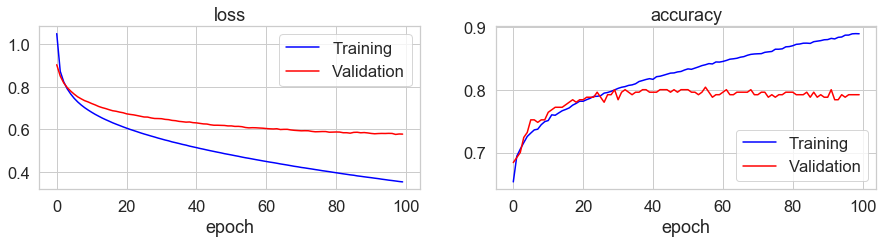

In [31]:
training_plot(hist_2)

#### Model_2 evaluation

In [34]:
model_2 = load_model('best-wiehgts-model_2-098-0.575-0.792.hdf5')

dev_loss, dev_accuracy = model_2.evaluate(X_dev, y_dev, verbose=1)
test_loss, test_accuracy = model_2.evaluate(X_test, y_test, verbose=1)
print("Dev: accuracy = %f  ;  loss = %f" % (dev_accuracy, dev_loss))
print("Test: accuracy = %f  ;  loss = %f" % (test_accuracy, test_loss))

251/251 [==============================] - 0s 1ms/step
Dev: accuracy = 0.792000  ;  loss = 0.575205
Test: accuracy = 0.780876  ;  loss = 0.611390


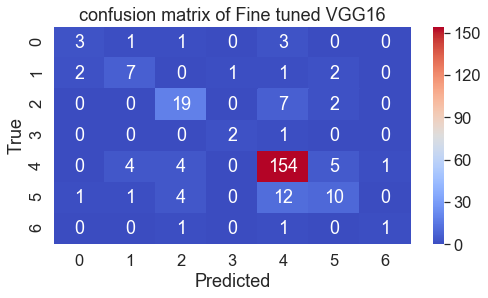

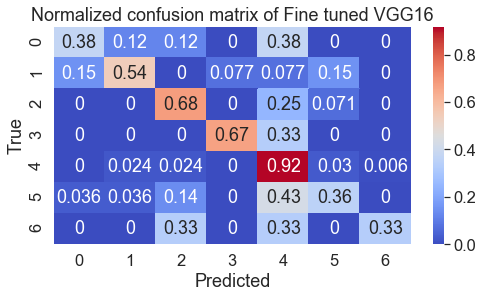

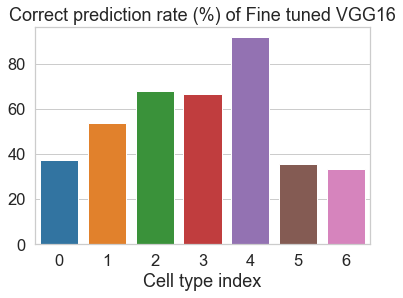

In [35]:
y_pred = model_2.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test,axis=1)
confusion_matrix_plot(y_true,y_pred_classes,'Fine tuned VGG16')

# Simulation of new test image classification using Model_2

#### The following functions obtain and plot the intermediate layer outputs

In [36]:
def get_featuremaps(model,layer_idx,new_image):
    get_activations = K.function([model.layers[0].input,K.learning_phase()],[model.layers[layer_idx].output])
    activations = get_activations([new_image,0])
    return activations
def plot_intermediate_layer(model,layer_idx,new_image):
    layer_num = layer_idx
    activations = get_featuremaps(model,int(layer_num),new_image)
    feature_maps = activations[0][0]

    num_of_filters = feature_maps.shape[2]
    subplot_side = int(np.ceil(np.sqrt(num_of_filters)))

    fig, axes = plt.subplots(subplot_side,subplot_side,figsize=(15,10))
    for ax in axes.flatten():
        ax.set_xticklabels([],[])
        ax.set_yticklabels([],[])
    for ax,filter_num in zip(axes.flatten(),range(num_of_filters)):
        ax.imshow(feature_maps[:,:,filter_num],interpolation='none')
        ax.set_aspect(aspect='auto')
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    fig.suptitle('filtered images of layer #' + str(layer_num)+' - number of filters: '+str(num_of_filters),fontsize=20)
    plt.savefig('featuremaps-layer-{}'.format(layer_idx)+'.png')
    plt.show()

#### New test image selection

In [37]:
df_sd_test = pd.read_csv(os.path.join('HAM10000_metadata.csv'))
df_sd_test['path'] = df_sd_test['image_id'].map(imageid_path_dict.get)
df_sd_test['cell_type'] = df_sd_test['dx'].map(lesion_type_dict.get) 
df_sd_test['cell_type_idx'] = pd.Categorical(df_sd['cell_type']).codes

In [38]:
new_test_image_id = 'ISIC_0029436'
true_cell_type_idx = df_sd_test[df_sd_test['image_id']==new_test_image_id]['cell_type_idx'].values[0]
df_sd_test[df_sd_test['image_id']==new_test_image_id]

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
3902,HAM_0006786,ISIC_0029436,nv,follow_up,50.0,female,lower extremity,HAM10000_images_part_2\ISIC_0029436.jpg,Melanocytic nevi,4


In [39]:
test_image = cv2.imread('HAM10000_images_part_2/'+new_test_image_id+'.jpg')
test_image = cv2.resize(test_image,(img_cols,img_rows))
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
test_image_original = test_image.copy()
test_image_flat = test_image.flatten()
test_image_flat = scale(test_image_flat)
test_image =test_image_flat.reshape(1,img_rows,img_cols,img_channels)

#### New test image (original)

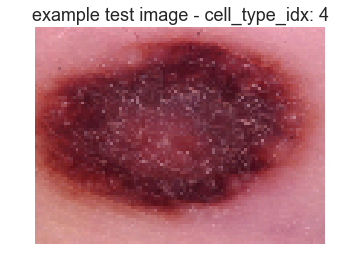

In [40]:
plt.imshow(test_image_original)
plt.axis('off')
plt.title('example test image - cell_type_idx: '+str(true_cell_type_idx))
plt.show()

#### Intermediate layer outputs

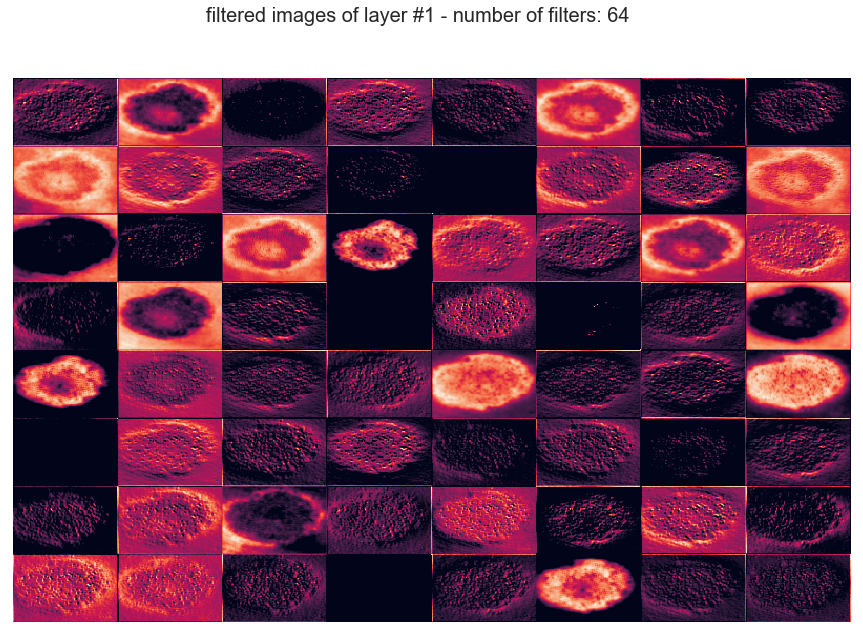

In [41]:
plot_intermediate_layer(model_2,1,test_image)

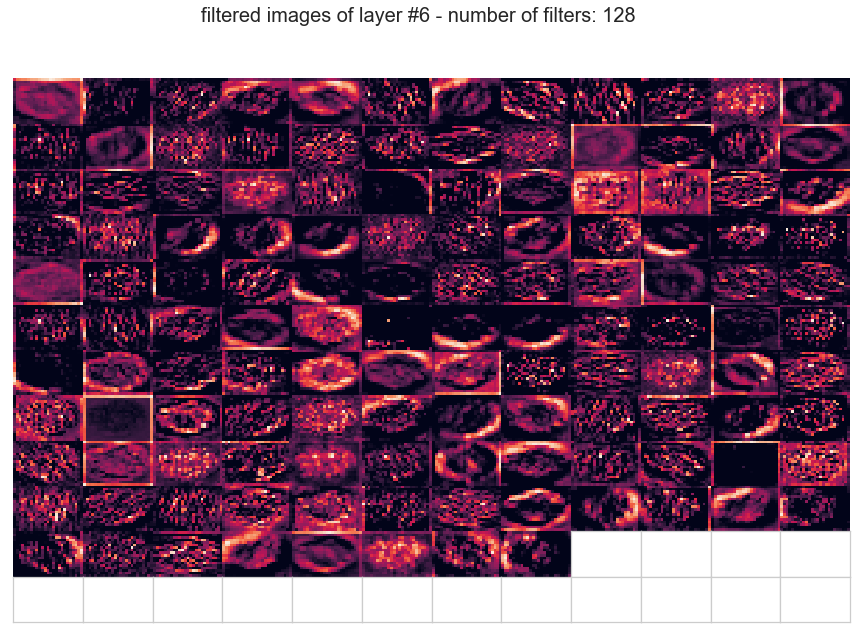

In [42]:
plot_intermediate_layer(model_2,6,test_image)

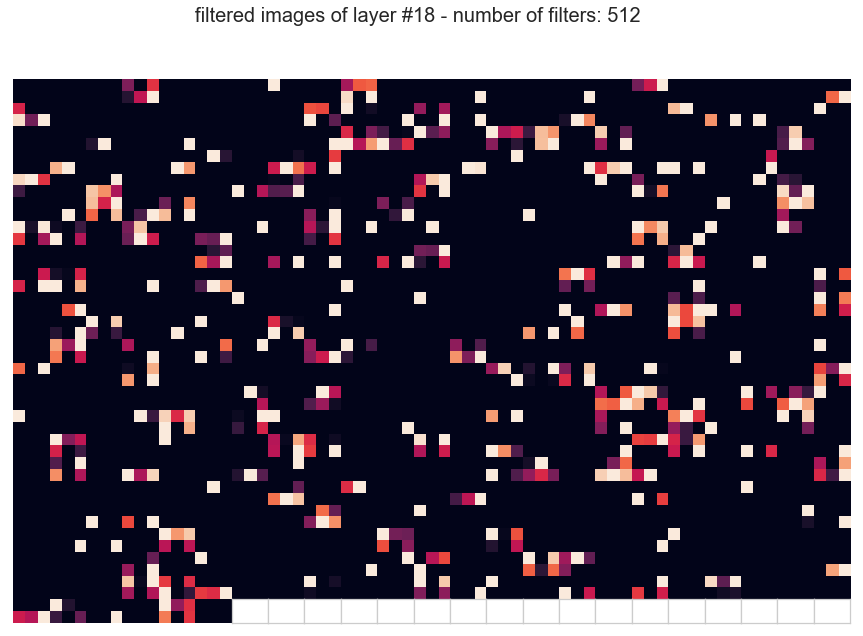

In [43]:
plot_intermediate_layer(model_2,18,test_image)

#### Test image prediction

In [44]:
test_image_pred = model_2.predict(test_image)
test_image_pred_classes = np.argmax(test_image_pred,axis=1)
print('true cell_type_idx: {}'.format(true_cell_type_idx))
print('predicted cell_type_idx: {}'.format(test_image_pred_classes[0]))

true cell_type_idx: 4
predicted cell_type_idx: 4


# Conclusion
This interesting image dataset was explored using two CNN models. The first one was the roughly tuned custom CNN with relatively shallow depth. The second one was the pre-trained VGG16 models where only the last three layers were fine-tuned. In general, both models performed relatively well with classification accuracy of ~ 77% and 78% on the test set, respectively. In the first model, the most misclassified cancer type was "Dermatofibroma" with a cell type index of 3. This was somewhat expected from EDA as there was the least amount of information available for this cancer class. However, in the second model, the accuracy of "Dermatofibroma" increased to ~66% while compromsing others to some extent. 

For further optimization, the class imbalance problem can be addressed in more detail. For example, only the cancer type images with least amount of original information (i.e. "Dermatofibroma", "Vascular lesions" and "Actinic keratoses") can be arbitrarily augmented or even the downsampling of "Melanocytic nevi" can be considered. In addition, based on the learning curve, it seems like that the model_2 suffers from high variance issue. Some regularization method can be tried to further improve the classification accuracy of model_2.

The constructed models are invaluable in the field of biomedical diagnostics. Given the new image, such models can quickly suggest the possible cancer type to clinicians so that they don't need to start the diagnosis from the scratch. In collaboration with experienced human clinicans, the prediction accuracy may become even higher and this will lead to other positive consequences to the patients as well (i.e. shorter waiting time, lower cost, etc). As more data becomes available, the prediction accuracy of such model is expected to increase further with properly constructed CNN architecture.  